In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-05-31 23:46:21.821518: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-05-31 23:46:21.843532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 23:46:21.843900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-05-31 23:46:21.844082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-31 23:46:21.845303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-31 23:46:21.846528: I tensorflow/st

In [5]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

In [6]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
# SIZE = 224
SIZE = 160          # It was 224, but in order for the current autoencoder model configuration work adequately, we changed it 228

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [7]:
batch_size = 15
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",           # For work laptop
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

Found 179 images belonging to 1 classes.


In [8]:
validation_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 1 classes.


In [9]:
anomaly_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 6 images belonging to 1 classes.


In [10]:
test_set_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [11]:
images_in_batch = next(train_generator)[0]
print(type(images_in_batch))
print(len(images_in_batch))
print(tf.reduce_min(images_in_batch), tf.reduce_max(images_in_batch))

<class 'numpy.ndarray'>
15


2023-05-31 23:25:26.001845: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-05-31 23:25:26.022679: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-05-31 23:25:26.023141: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb2300010b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-31 23:25:26.023157: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-31 23:25:26.094951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 23:25:26.095335: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4449170 initialized for platform CUDA (this does not guarantee that XLA will

tf.Tensor(0.011764707, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [12]:
print(images_in_batch.shape)

(15, 160, 160, 3)


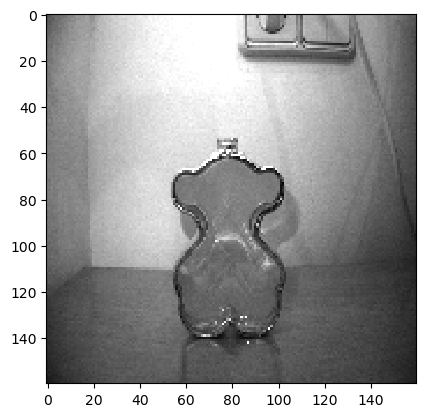

In [13]:
single_img = images_in_batch[0]
plt.imshow(single_img)

# Configuring the Autoencoder netwrok

In [15]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, LayerNormalization, BatchNormalization, ReLU, Flatten, Layer
DIM = SIZE
class DepthToSpace(Layer):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def call(self, inputs):
        output = tf.transpose(inputs, [0, 2, 3, 1])
        (batch_size, input_height, input_width, input_depth) = tf.shape(output)
        output_depth = input_depth // self.block_size_sq
        output_width = input_width * self.block_size
        output_height = input_height * self.block_size
        t_1 = tf.reshape(output, [batch_size, input_height, input_width, self.block_size_sq, output_depth])
        spl = tf.split(t_1, self.block_size, axis=3)
        stacks = [tf.reshape(t_t, [batch_size, input_height, output_width, output_depth]) for t_t in spl]
        output = tf.stack(stacks, axis=0)
        output = tf.transpose(output, [1, 2, 0, 3, 4])
        output = tf.reshape(output, [batch_size, output_height, output_width, output_depth])
        output = tf.transpose(output, [0, 3, 1, 2])
        return output

class UpSampleConv(Layer):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim, kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def call(self, inputs):
        output = inputs
        output = tf.concat((output, output, output, output), axis=1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output

class ConvMeanPool(Layer):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim, kernel_size, he_init=self.he_init)

    def call(self, inputs):
        output = self.conv(inputs)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] + output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output

class MyConvo2d(Layer):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1) / 2)
        self.conv = Conv2D(output_dim, kernel_size, strides=stride, padding='same', use_bias=bias)

    def call(self, inputs):
        output = self.conv(inputs)
        return output

class MeanPoolConv(Layer):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim, kernel_size, he_init=self.he_init)

    def call(self, inputs):
        output = inputs
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] + output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output

class ResidualBlock(Layer):
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = ReLU()
        self.relu2 = ReLU()

        if resample == 'down':
            self.bn1 = LayerNormalization(axis=[1, 2, 3])
            self.bn2 = LayerNormalization(axis=[1, 2, 3])
        elif resample == 'up':
            self.bn1 = BatchNormalization()
            self.bn2 = BatchNormalization()
        elif resample == None:
            self.bn1 = BatchNormalization()
            self.bn2 = LayerNormalization(axis=[1, 2, 3])
        else:
            raise Exception('Invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(output_dim, output_dim, kernel_size=kernel_size)
        elif resample == None:
            self.conv_shortcut = MyConvo2d(input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('Invalid resample value')

    def call(self, inputs):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = inputs
        else:
            shortcut = self.conv_shortcut(inputs)

        output = inputs
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output

class Encoder(Layer):
    def __init__(self, dim, output_dim, drop_rate=0.0):
        super(Encoder, self).__init__()
        self.dropout = Dropout(drop_rate)
        self.conv_in = Conv2D(dim, 3, 1, padding='same')
        self.res1 = ResidualBlock(dim, dim * 2, 3, 'down', 160)
        self.res2 = ResidualBlock(dim * 2, dim * 4, 3, 'down', 80)
        self.res3 = ResidualBlock(dim * 4, dim * 8, 3, 'down', 40)
        self.res4 = ResidualBlock(dim * 8, dim * 8, 3, 'down', 20)
        self.fc = Dense(output_dim)

    def call(self, inputs):
        x = self.dropout(inputs)
        x = self.conv_in(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = tf.reshape(x, (x.shape[0], -1))
        x = self.fc(x)
        return tf.tanh(x)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, dim):
        super(Decoder, self).__init__()
        self.fc = tf.keras.layers.Dense(10 * 10 * 8 * dim)
        self.res4 = ResidualBlock(dim * 8, dim * 8, 3, resample=None, hw=20)
        self.res3 = ResidualBlock(dim * 4, dim * 8, 3, resample='up', hw=40)
        self.res2 = ResidualBlock(dim * 2, dim * 4, 3, resample='up', hw=80)
        self.res1 = ResidualBlock(dim, dim * 2, 3, resample='up', hw=160)
        self.conv_out = tf.keras.layers.Conv2DTranspose(3, 3, 1, padding='same')

    def call(self, inputs):
        x = tf.tanh(inputs)
        x = self.fc(x)
        x = tf.reshape(x, (-1, 10, 10, 8 * self.dim))
        x = self.res4(x)
        x = self.res3(x)
        x = self.res2(x)
        x = self.res1(x)
        x = self.conv_out(x)
        return x

# autoencoder = keras.Model(inputs, decoder(encoder(inputs)),
# 			name="autoencoder")


THis model is too complex to recreate in tensorflow. Stop here.